# Estimating soil water balance with LAI

This is an example of using Verde LAI and weather data to correlate changes in crop LAI with changes in the soil water balance.

## A first GraphQL query

We will use Agrimetrics GraphQL API to retrieve data about fields. Each query must be sent with a subscription key; for more information see the [introductory tutorial](../graphql-examples/using_graphql_tutorial.ipynb) and the [Agrimetrics developer portal](https://developer.agrimetrics.co.uk).

In [2]:
# Imports, Agrimetrics API key, GraphQL url and common API headers
import os
import io
import math

GRAPHQL_ENDPOINT = "https://api.agrimetrics.co.uk/query-api/v1/graphql"

if "API_KEY" in os.environ:
    API_KEY = os.environ["API_KEY"]
else:
    API_KEY = input("Query API Subscription Key: ").strip()

headers = {
    'Accept': "application/json",
    'Ocp-Apim-Subscription-Key': API_KEY,
    'Content-Type': "application/json",
    'Accept-Encoding': "gzip, deflate, br",
}

## Retrieving information for a chosen field

In [3]:
chosen_field = 'https://data.agrimetrics.co.uk/fields/pE9QRHmyDMX9BzvtP8hvcg'

A GraphQL query is easily sent with the requests package. Queries are posted with a JSON body containing a query and, optionally, variables. The subscription key is given in the request header Ocp-Apim-Subscription-key. For more information on Agrimetrics GraphQL API and how to build queries, see [Agrimetrics Graph Explorer portal](https://app.agrimetrics.co.uk/#/graph-explorer).

In [4]:
import requests

# get centroid, elevation and crop type of chosen field
response = requests.post(GRAPHQL_ENDPOINT, headers=headers, json={
    'query': '''
        query getFieldIdAtLocation($fieldID: [ID!]!) {
            fields(where: {id: {EQ: $fieldID}}) {
                shape
                elevation { value }
                sownCrop {
                    harvestYear
                    cropType
                }

            }
        }

    ''',
    'variables': {'fieldID': chosen_field}
})
response.raise_for_status()

The response from the GraphQL API is a JSON document.

In [5]:
chosen_field_info = response.json()

longitude, latitude = chosen_field_info['data']['fields'][0]['shape']['features'][0]['geometry']['coordinates']
elevation = chosen_field_info['data']['fields'][0]['elevation']['value']

print(f'Chosen field longitude: {longitude}, latitude: {latitude}, elevation: {elevation}m')

crop_species = chosen_field_info['data']['fields'][0]['sownCrop'][-1]['cropType']

print(f'Crop in chosen field: {crop_species}')

Chosen field longitude: -0.941086646, latitude: 51.410013151, elevation: 47m
Crop in chosen field: GRASS


## Accessing Verde field information

For accessing Verde field attributes, we must first register our Agrimetrics subscription for crop observations. It is necessary to register for each field we want Verde attributes. This is achieved by a GraphQL mutation:

In [6]:
response = requests.post(GRAPHQL_ENDPOINT, headers=headers, json={
    'query': '''
        mutation registerCropObservations($registrations: [CropObservationRegistrationInput!]!) {
            account {
                premiumData {
                    addCropObservationRegistrations(registrations: $registrations) {
                        id 
                    }
                }
            }
        }
    ''',
    'variables': {'registrations': {'fieldId': chosen_field, 'layerType': 'CROP_SPECIFIC', 'cropType': 'GRASS', 'season': 'SEP2017TOSEP2018'}}
})

response.raise_for_status()


It can take up to an hour (or sometimes longer, at peak times) for a registration to be processed, so you may need to wait for your requested data to become available. In the case of this example, the data should be available immediately.

Once our interest for the field has been registered, we can retrieve Verde data for this field. We will be returning a timeseries of `LAI` values. 

In [7]:
import numpy as np
import pandas as pd

# Get LAI for subscribed field
response = requests.post(GRAPHQL_ENDPOINT, headers=headers, json={
    'query': '''
        query getFieldIdAtLocation($fieldId: [ID!]!) {
            fields(where: {id: {EQ: $fieldId}}) {
                id 
                cropObservations {
                    leafAreaIndex {
                        mean
                        dateTime
                    }

                }
            }
        }
    ''',
    'variables': {'fieldId': chosen_field}
})
response.raise_for_status()
results = response.json()
lai = pd.io.json.json_normalize(
    results['data']['fields'],
    record_path=['cropObservations', 'leafAreaIndex'],
)
lai['date_time'] = pd.to_datetime(lai['dateTime'])
lai['lai'] = lai['mean']
lai = lai[['date_time', 'lai']]
lai.head()

,date_time,lai
0,2017-09-09 11:06:51+00:00,1.387510
1,2017-10-29 11:12:01+00:00,0.646048
2,2017-11-23 11:13:49+00:00,0.676587
3,2017-12-08 11:14:41+00:00,0.713337
4,2017-12-18 11:14:51+00:00,0.508427


To plot the data we convert the datetime column into a python datetime object and average daily points due to occasional multiple LAI values from different satellites on the same day.

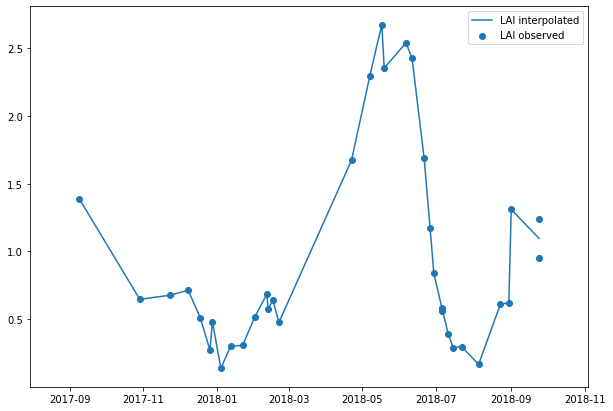

In [9]:
from datetime import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

lai['date'] = lai['date_time'].apply(lambda dt: datetime(dt.year, dt.month, dt.day))
lai_daily_mean = lai.groupby('date').mean()
interpolated_daily_lai = lai_daily_mean.resample('1D').interpolate(method ='linear')

fig = plt.figure(figsize=(10,7))
plt.scatter(lai['date'], lai['lai'], label='LAI observed')
plt.plot(interpolated_daily_lai.index, interpolated_daily_lai['lai'], label='LAI interpolated')
plt.legend()

## Obtaining weather data

We run a query to retrieve weather data from the GraphQL API. These data will be used to calculate our soil water balance.

We return:
* Total Daily Rainfall
* Daily Solar Insolation
* Daily Maximum Temperature
* Daily Minimum Temperature
* Daily Mean Temperature

For this case study, given the large data volume the data is retrieved incrementally with a cursor.


In [10]:

weather_variables = ['rainfallTotalDaily', 'solarInsolationDaily', 'temperatureMaxDaily', 'temperatureMeanDaily', 'temperatureMinDaily']
def retrieve_weather(field_id, variable):
    weather_data = []
    cursor = ''
    while True:
        response = requests.post(GRAPHQL_ENDPOINT, headers=headers, json={
            'query': '''
                query getWeather($fieldId: [ID!]!, $cursor: String!) {{
                  fields(where: {{ id: {{EQ: $fieldId}} }}) {{
                    weatherObservations(after: $cursor, where: {{ date: {{GE: "2017-09-09", LE: "2018-09-25"}} }}) {{
                      cursor
                      {variable} {{
                        value
                        dateTime
                      }}
                    }}
                  }}
                }}
            '''.format(variable=variable),
            'variables': {'fieldId': chosen_field, 'cursor': cursor}
        })
        response.raise_for_status()
        results = response.json()
        response_data = pd.io.json.json_normalize(
            results['data']['fields'],
            record_path=['weatherObservations', variable],
        )
        response_data['date_time'] = pd.to_datetime(response_data['dateTime'])
        response_data.set_index('date_time', inplace=True)
        response_data[variable] = response_data['value']
        cursor = results['data']['fields'][0]['weatherObservations'].get('cursor')
        weather_data.append(response_data[[variable]])
        if cursor is None:
            break
    return pd.concat(weather_data, axis=0)

weather_data = [] 

for weather_variable in weather_variables:
    variable_data = retrieve_weather(chosen_field, weather_variable)
    weather_data.append(variable_data)

weather = pd.concat(weather_data, axis=1)

weather.head()

,rainfallTotalDaily,solarInsolationDaily,temperatureMaxDaily,temperatureMeanDaily,temperatureMinDaily
date_time,,,,,
2017-09-09 00:00:00+00:00,8.4,3.64,18.1,13.6,9.2
2017-09-10 00:00:00+00:00,1.7,1.71,16.7,12.1,7.4
2017-09-11 00:00:00+00:00,3.6,3.51,18.3,14.5,10.7
2017-09-12 00:00:00+00:00,2.8,3.83,18.0,13.7,9.4
2017-09-13 00:00:00+00:00,1.2,3.33,17.3,14.5,11.6


How does LAI change in relation to daily rainfall?

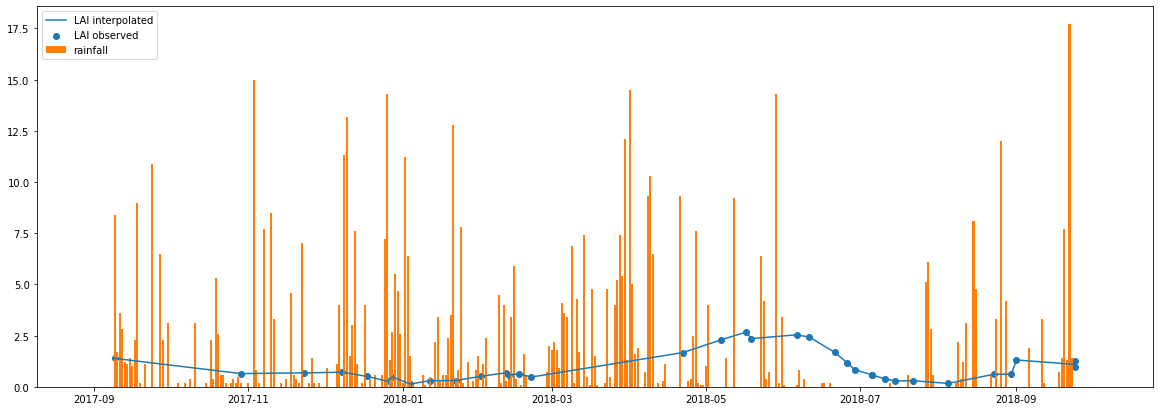

In [11]:
lai['date'] = lai['date_time'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, tzinfo=dt.tzinfo))
lai_daily_mean = lai.groupby('date').mean()
interpolated_daily_lai = lai_daily_mean.resample('1D').interpolate(method ='linear')

fig = plt.figure(figsize=(20,7))
plt.scatter(lai['date'], lai['lai'], label='LAI observed')
plt.plot(interpolated_daily_lai.index, interpolated_daily_lai['lai'], label='LAI interpolated')
plt.bar(weather.index, weather['rainfallTotalDaily'], label='rainfall')
plt.legend()

This plot shows an intuitive relationship between LAI and rainfall frequency, with grass LAI low in the winter irrespective of the rain, LAI then increasing in the spring and through the summer but then LAI rapidly declining during the period in late summer where there is very little rainfall.

## Calculating Reference Evapotranspiration

Let's now see if we can work out more details of the plant and soil water balance using well known equations for calculating evapotranspiration. We will use the Hargreaves equation for calculating evapotranspiration (Hargreaves and Samani, 1985).

In [12]:
from eto import ETo

eto = ETo()
frequency = 'D'
eto_data = pd.DataFrame(data={
    'R_s': weather['solarInsolationDaily'],
    'T_max': weather['temperatureMaxDaily'],
    'T_min': weather['temperatureMinDaily'],
    'T_mean': weather['temperatureMeanDaily'],
})
eto.param_est(eto_data, frequency, elevation, latitude, longitude)
weather['ETo'] = eto.eto_hargreaves()

We next use LAI to adjust the reference evapotranspiration `ETo` according to the transpirable leaf area to calculate Potential Evapotranspiration `PET`.

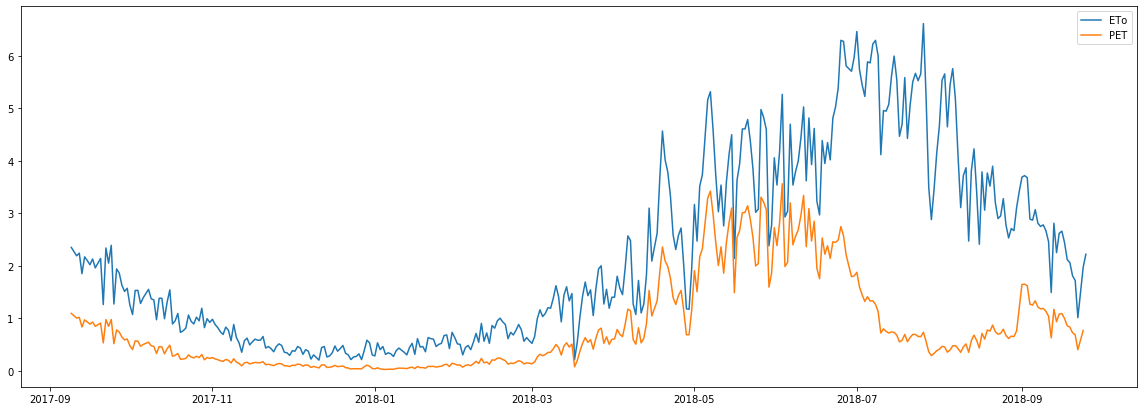

In [13]:
crop = weather.join(interpolated_daily_lai)
crop['PET'] = crop.apply(lambda day: day['ETo'] * (1 - math.exp(-0.45*day['lai'])), axis=1)

fig = plt.figure(figsize=(20,7))
plt.plot(crop.index, crop['ETo'], label='ETo')
plt.plot(crop.index, crop['PET'], label='PET')
plt.legend()

This shows a key difference between reference evapotranspiration and potential evapotranspiration in the late summer of 2018 because of the lack of photosynthetic leaves of the grass crop in that time window.

## Soil Water Balance

We estimate the soil hydraulic properties using top-soil physical properties such as 'Fraction of Clay', 'Fraction of Sand', and 'Organic Matter Percentage'.

These utilise the Saxton & Rawls method for conversion into soil water content estimates (Saxton and Rawls, 2006).

In [14]:
def theta_pwp(sand_frac, clay_frac, om_perc):
    ''' Water content in root zone at saturation '''
    sand_imp = (-0.024 * sand_frac)
    clay_imp = (0.487 * clay_frac)
    om_imp = (0.006 * om_perc)

    interactions = (0.005 * (sand_frac * om_perc)) - (0.013 * (clay_frac * om_perc)) + (0.068 * (sand_frac * clay_frac))

    theta_pwp_t = sand_imp + clay_imp + om_imp + interactions + 0.031

    return theta_pwp_t + (0.14 * theta_pwp_t - 0.02)


def theta_fc(sand_frac, clay_frac, om_perc):
    ''' Water content in root zone at field capacity '''
    sand_imp = (-0.251 * sand_frac)
    clay_imp = (0.195 * clay_frac)
    om_imp = (0.011 * om_perc)

    interactions = (0.006 * (sand_frac * om_perc)) - (0.027 * (clay_frac * om_perc)) + (0.452 * (sand_frac * clay_frac))

    theta_fc_t = sand_imp + clay_imp + om_imp + interactions + 0.299

    return theta_fc_t + ((1.283 * (theta_fc_t ** 2)) - (0.374 * theta_fc_t) - 0.015)



def theta_s_minus_fc(sand_frac, clay_frac, om_perc):
    ''' available water content in root zone '''
    sand_imp = (0.278 * sand_frac)
    clay_imp = (0.034 * clay_frac)
    om_imp = (0.022 * om_perc)

    interactions = (-0.018 * (sand_frac * om_perc)) - (0.027 * (clay_frac * om_perc)) - (0.584 * (sand_frac * clay_frac))

    first_soln = sand_imp + clay_imp + om_imp + interactions + 0.078

    return first_soln + (0.636 * first_soln - 0.107)


def theta_s(sand_frac, clay_frac, om_perc):
    ''' Water content in root zone at saturation '''
    fc = theta_fc(sand_frac, clay_frac, om_perc)
    aw = theta_s_minus_fc(sand_frac, clay_frac, om_perc)

    return fc + aw - (0.097 * sand_frac) + 0.043

def soil_organic_matter(carbon_concentration):
    '''conversion of carbon concentration from milligrams per kilogram carbon to organic matter percentage'''
    carbon_concentration_percentage = 100 * carbon_concentration/(1000 * 1000)

    return carbon_concentration_percentage * 1.724





This query retrieves the required physical properties of the top-soil for the soil water balance.

In [15]:
response = requests.post(GRAPHQL_ENDPOINT, headers=headers, json={
    'query':'''
        query getSoil($fieldId: [ID!]!) {
            fields(where: {id: {EQ: $fieldId}}) {
                soil {
                    topSoil {
                        texture {
                            clayPercentage
                            sandPercentage
                            siltPercentage
                        }
                        chemicalProperties {
                            carbonConcentration {
                                value
                            }
                        }
                    }
                }
            }
        }
    ''',
    'variables': {'fieldId': chosen_field}
})

response.raise_for_status()
results = response.json()
carbon_concentration = results['data']['fields'][0]['soil']['topSoil']['chemicalProperties']['carbonConcentration']['value']
om_perc = soil_organic_matter(carbon_concentration)

clayPercentage = results['data']['fields'][0]['soil']['topSoil']['texture']['clayPercentage']
sandPercentage = results['data']['fields'][0]['soil']['topSoil']['texture']['sandPercentage']
soil_fc = theta_fc(sandPercentage/100, clayPercentage/100, om_perc)
soil_pwp = theta_pwp(sandPercentage/100, clayPercentage/100, om_perc)
soil_s = theta_s(sandPercentage/100, clayPercentage/100, om_perc)

print('Soil organic matter percentage', round(om_perc))
print('Soil permanent wilting point:', round(soil_pwp,2))
print('field capacity:', round(soil_fc,2))
print('saturation:', round(soil_s,2))

Soil organic matter percentage 11
Soil permanent wilting point: 0.19
field capacity: 0.38
saturation: 0.68


We next compute soil water balance

In [16]:
from swb import calculate_soil_water

swb_data = pd.DataFrame(data={
    'crop_evapotranspiration': crop['PET'],
    'effective_precipitation': crop['rainfallTotalDaily']
})
swb_data['actual_net_irrigation'] = 0

soil_water_balance = calculate_soil_water(
    theta_s=soil_s,         # Water content at saturation, unit: mm
    theta_fc=soil_fc,       # Water content at field capacity, unit: mm
    theta_wp=soil_pwp,      # Water content at permanent wilting point, unit: mm
    zr=0.5,                 # Root, unit: m
    zr_factor=1000,         # Multiplier for mm conversion, unitless 
    p=0.5,                  # Soil water depletion fraction, unitless 
    draintime=2.2,          # Time to drain from saturation to field capacity, unit: days
    timeseries=swb_data,    # Time series of raindall and evapotranpiration
    theta_init=soil_fc*0.7, # Initial water content, unit: mm
    mif=0.5,                # The Malamos irrigation fraction, unitless 
)

We next plot how changes in the soil water affects the LAI of the crop.

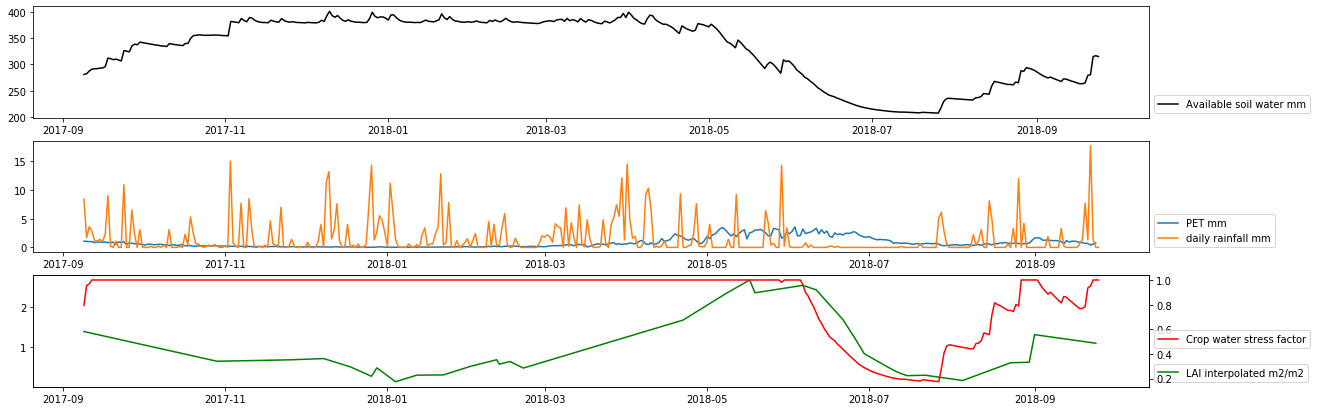

In [17]:
fig = plt.figure(figsize=(20,7))

ax1 = plt.subplot(3,1,1)

plt.plot(crop.index, soil_water_balance['timeseries']['theta']*1000, label='Available soil water mm', color='black')
plt.legend(bbox_to_anchor=(1, 0), loc='lower left')

ax2 = plt.subplot(3,1,2)

plt.plot(crop.index, crop['PET'], label='PET mm')
plt.plot(crop.index, crop['rainfallTotalDaily'], label='daily rainfall mm')
plt.legend(bbox_to_anchor=(1, 0), loc='lower left')


ax3 = plt.subplot(3,1,3)

plt.plot(crop.index, crop['lai'], label='LAI interpolated m2/m2', color='green')
plt.legend(bbox_to_anchor=(1.0, 0), loc='lower left')
ax4 = ax3.twinx()
plt.plot(crop.index, soil_water_balance['timeseries']['ks'], label='Crop water stress factor',color='red')
ax4.legend(bbox_to_anchor=(1, 0.3), loc='lower left')



This final plot shows the relationship between the plant and soil water properties. Soil Water content is obviously influenced by daily rainfall. Therefore the soil water content is close to the field capacity from November 2017 to May 2018. During this time the LAI values are increasing. After that, there is a period of low rainfall. This cause soil water content to decrease and the crop water stress factor to decrease, indicating higher crop stress for water. This is associated with the decline in LAI. At the beginning of autumn, the rain returns, crop water stress decreases (factor increases) and LAI begins to recover.

## References
Hargreaves, G.H. and Samani, Z.A. (1985) Reference Crop Evapotranspiration from Temperature. Applied Engineering in Agriculture, 1, 96-99.

Saxton, K.E. and Rawls, W.J. (2006) Soil Water Characteristic Estimates by Texture and Organic Matter for Hydrologic Solutions. Soil Sci. Soc. Am. J., 70, 1569 – 1578.